In [615]:

from sqlalchemy import create_engine
import sqlalchemy
import psycopg2
import pandas as pd
import numpy as np # linear algebra

#from category_encoders import  OneHotEncoder, OrdinalEncoder
import category_encoders as ce


import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

import plotly
import plotly.express as px
print(plotly.__version__)

import requests # Импортируем библиотеку requests
from pprint import pprint # Импортируем функцию pprint()
from bs4 import BeautifulSoup # Импортируем библиотеку BeautifulSoup

from comet_ml import Experiment

import re


5.10.0


In [427]:
%pip install termcolor

from termcolor import colored

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [428]:
experiment = Experiment(
    api_key='eWvQPKCUdK6nguyW4dSmT52ew',
    project_name='EDA-project3',
    workspace='kdunaev-a10',
    log_code=True
)

experiment.log_code(file_name="EDA_Project_3_model.ipynb")

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/kdunaev-a10/eda-project3/27d744632b7246629ab386ff6a039b9e
COMET INFO:   Parameters:
COMET INFO:     bootstrap                : True
COMET INFO:     ccp_alpha                : 0.0
COMET INFO:     criterion                : squared_error
COMET INFO:     max_depth                : 1
COMET INFO:     max_features             : 1.0
COMET INFO:     max_leaf_nodes           : 1
COMET INFO:     max_samples              : 1
COMET INFO:     min_impurity_decrease    : 0.0
COMET INFO:     min_samples_leaf         : 1
COMET INFO:     min_samples_split        : 2
COMET INFO:     min_weight_fraction_leaf : 0.0
COMET INFO:     n_estimators             : 100
COMET INFO:     n_jobs                   : 1
COMET INFO:     oob_score                : False
COMET INFO:  

[('EDA_Project_3_model.ipynb',
  {'web': 'https://www.comet.com/api/asset/download?assetId=b85909bc5a924a5ca81cbf89eb641981&experimentKey=e2d052cc1ae847c7be6e1ed91d281671',
   'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=b85909bc5a924a5ca81cbf89eb641981&experimentKey=e2d052cc1ae847c7be6e1ed91d281671',
   'assetId': 'b85909bc5a924a5ca81cbf89eb641981'})]

## 0. Load data

In [429]:
hotels = pd.read_csv('data/hotels.csv')
hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [430]:
display(hotels.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

None

In [617]:
#add attribute sample for the test!
hotels['sample'] = 1


## 1 ГРУППА ПРИЗНАКОВ ХАРКТЕРИЗУЮЩИХ ОТЕЛЬ

    Название и Адрес отеля ('hotel_address', 'hotel_name')
    Координаты отеля - Географическая широта и долгота отеля ('lat', 'lng')
    Средний балл отеля за последний год ('average_score')
    Общее количество отзывов об отеле ('total_number_of_reviews')
    Общее количество оценок без отзывов ('additional_number_of_scoring')



### 1.1 check the address and hotel names
dublicated hotel names do not affect the model

In [431]:
# исследуем данные о названии на наличие пропусков и дубликатов:
pivot_n = hotels[['hotel_address', 'hotel_name']].groupby(by='hotel_name').nunique()

display(pivot_n['hotel_address'].sort_values().tail(5))

name_rep = pivot_n[pivot_n['hotel_address'] > 1].index.to_list()
display(name_rep)

mask = hotels['hotel_name'].isin(name_rep)

addresses_rep = hotels[mask][['hotel_name', 'hotel_address']].value_counts()
print('Дублирование Названия отеля:', 'green')
display(addresses_rep)

hotel_name
HCC Regente             1
H10 Urquinaona Plaza    1
Haymarket Hotel         1
pentahotel Vienna       1
Hotel Regina            3
Name: hotel_address, dtype: int64

['Hotel Regina']

Дублирование Названия отеля: green


hotel_name    hotel_address                                             
Hotel Regina  Bergara 2 4 Eixample 08002 Barcelona Spain                    440
              Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria           222
              Via Cesare Correnti 13 Milan City Center 20123 Milan Italy     47
dtype: int64

In [432]:
import re

regex1 = '\((?:[^)]*)\){1,}'
regex2 = '\([^)]*(?:\)){1,}'

addr = 'Holland Park Avenue Kensington and Chelsea London W11 4UL United Kingdom'
addr = '216 Avenue Jean Jaures 19th arr 75019 Paris France'
print(str1)
#str2 = re.findall(regex1, '216 Avenue Jean Jaures 19th arr 75019 Paris France')[-1]
if re.findall('United Kingdom', addr):
    city = addr.split(' ')[-5:-6:-1][0]
    country = 'United Kingdom'
else:
    city = addr.split(' ')[-2:-3:-1][0]
    country = addr.split(' ')[-1:-2:-1][0]
print(city, country)

United Kingdom
Paris France


In [433]:
 
addresses = pd.Series(hotels['hotel_address'].unique())
display(addresses)


0       Stratton Street Mayfair Westminster Borough Lo...
1       130 134 Southampton Row Camden London WC1B 5AF...
2        151 bis Rue de Rennes 6th arr 75006 Paris France
3       216 Avenue Jean Jaures 19th arr 75019 Paris Fr...
4               Molenwerf 1 1014 AG Amsterdam Netherlands
                              ...                        
1488      Viriotgasse 5 09 Alsergrund 1090 Vienna Austria
1489             8 rue d Anjou 8th arr 75008 Paris France
1490    Prinsengracht 717 Amsterdam City Center 1017 J...
1491    43 Rue De l Abb Gr goire 6th arr 75006 Paris F...
1492    Johann Staud Stra e 32 16 Ottakring 1160 Vienn...
Length: 1493, dtype: object

### 1.2 The city is most important characteristic in the address line

In [434]:

def get_city(addr):
    """Find the name of the city

    Args:
        addr (str): the address string 

    Returns:
        str: the city name
    """
    
    if re.findall('United Kingdom', addr):
        city = addr.split(' ')[-5:-6:-1][0]
        country = 'United Kingdom'
        
    else:
        city = addr.split(' ')[-2:-3:-1][0]
        country = addr.split(' ')[-1:-2:-1][0]
        
    return city

def get_country(addr):
    """Find the name of the city

    Args:
        addr (str): the address string 

    Returns:
        str: the city name
    """
    
    if re.findall('United Kingdom', addr):
        city = addr.split(' ')[-5:-6:-1][0]
        country = 'United Kingdom'
        
    else:
        city = addr.split(' ')[-2:-3:-1][0]
        country = addr.split(' ')[-1:-2:-1][0]
        
    return country

hotels['city'] = hotels['hotel_address'].apply(get_city)
hotels['country'] = hotels['hotel_address'].apply(get_country)

display(hotels[['hotel_address', 'city', 'country']].head(5))
display(hotels['city'].unique())
display(hotels['country'].unique())

#display(addresses.groupby(['country', 'city']).count())

,hotel_address,city,country
0,Stratton Street Mayfair Westminster Borough Lo...,London,United Kingdom
1,130 134 Southampton Row Camden London WC1B 5AF...,London,United Kingdom
2,151 bis Rue de Rennes 6th arr 75006 Paris France,Paris,France
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,Paris,France
4,Molenwerf 1 1014 AG Amsterdam Netherlands,Amsterdam,Netherlands


array(['London', 'Paris', 'Amsterdam', 'Milan', 'Vienna', 'Barcelona'],
      dtype=object)

array(['United Kingdom', 'France', 'Netherlands', 'Italy', 'Austria',
       'Spain'], dtype=object)

## 1.3 Check the missing values and fill them up
use the city center coordinates for filling up the missing hotel coordinates

In [435]:
hotels_nulls = hotels.isnull().sum()
print('Признаки и количество пропущенных значений:\n{}'.format(hotels_nulls[hotels_nulls > 0]))

#display(hotels[(hotels['lat'].isnull()) | (hotels['lng'].isnull())] )
coordinates_empty = list(hotels[(hotels['lat'].isnull()) | (hotels['lng'].isnull())].index)
#display(coordinates_empty)

hotels['coordinates_true'] = 1
hotels.loc[coordinates_empty, 'coordinates_true'] = 0

#заполним пустые координаты отеля значениями координат города:

values_lat = {
    'Milan': 45.4642700,
    'Amsterdam': 52.3740300,
    'Barcelona': 41.3887900,
    'London': 51.5085300,
    'Paris': 48.8534100,
    'Vienna': 48.2084900
}

values_lng = {
    'Milan': 9.1895100,
    'Amsterdam': 4.8896900,
    'Barcelona': 2.1589900,
    'London': -0.1257400,
    'Paris': 2.3488000,
    'Vienna': 16.3720800
}
hotels['lat'] = hotels[['city', 'lat']].apply(lambda x: values_lat[x.city] if np.isnan(x.lat) else x.lat, axis=1)
hotels['lng'] = hotels[['city', 'lng']].apply(lambda x: values_lng[x.city] if np.isnan(x.lng) else x.lng, axis=1)


Признаки и количество пропущенных значений:
lat    2448
lng    2448
dtype: int64


2023-02-05 13:06:26,997 - WARNING  - Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='www.comet.com', port=443): Read timed out. (read timeout=10)")': /clientlib/batch/logger/experiment/metric


In [436]:
display(hotels[(hotels['coordinates_true'] == 0)] )

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,city,country,coordinates_true
122,Savoyenstra e 2 16 Ottakring 1160 Vienna Austria,86,8/26/2016,8.3,Austria Trend Hotel Schloss Wilhelminenberg Wien,United States of America,Not much,3,1558,Bugs in our room Bad Wifi,7,3,2.5,"[' Leisure trip ', ' Couple ', ' Classic Room ...",342 day,48.20849,16.37208,Vienna,Austria,0
566,23 Rue Damr mont 18th arr 75018 Paris France,21,6/23/2016,8.3,Holiday Inn Paris Montmartre,United Kingdom,N a,3,298,Great location friendly and very helpful staff,8,2,7.1,"[' Leisure trip ', ' Family with older childre...",406 day,48.85341,2.34880,Paris,France,0
724,Josefst dter Stra e 10 12 08 Josefstadt 1080 V...,333,8/6/2015,8.3,Fleming s Selection Hotel Wien City,United Arab Emirates,The bed so comfortable and room design,8,3672,Lovely location and friendly staff Close the ...,13,4,9.6,"[' Leisure trip ', ' Solo traveler ', ' Superi...",728 day,48.20849,16.37208,Vienna,Austria,0
754,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...,214,1/4/2016,7.8,Hotel Atlanta,Romania,No Negative,0,2724,location near the city centre quiet clean,8,26,8.8,"[' Leisure trip ', ' Family with older childre...",577 day,48.20849,16.37208,Vienna,Austria,0
1137,4 rue de la P pini re 8th arr 75008 Paris France,172,1/5/2016,8.8,Maison Albar Hotel Paris Op ra Diamond,Luxembourg,The breakfast was to minimalist for this price,9,1524,No Positive,0,1,8.8,"[' Leisure trip ', ' Couple ', ' Executive Dou...",576 day,48.85341,2.34880,Paris,France,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386092,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,211,3/19/2017,8.6,Hotel City Central,India,Room could have been bigger slightly cramped ...,11,2923,Friendly and very helpful staff,7,2,8.8,"[' Business trip ', ' Solo traveler ', ' Singl...",137 day,48.20849,16.37208,Vienna,Austria,0
386465,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,211,7/4/2017,8.6,Hotel City Central,United Kingdom,Very expensive parking We thought it was 24 f...,24,2923,Central location and excellent breakfast,6,10,9.2,"[' Leisure trip ', ' Couple ', ' Standard Twin...",30 days,48.20849,16.37208,Vienna,Austria,0
386504,4 rue de la P pini re 8th arr 75008 Paris France,172,7/10/2017,8.8,Maison Albar Hotel Paris Op ra Diamond,Bangladesh,The rooms were a little small,7,1524,The staff were extremely helpful and friendly...,20,4,9.2,"[' Leisure trip ', ' Family with young childre...",24 days,48.85341,2.34880,Paris,France,0
386702,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,211,11/7/2016,8.6,Hotel City Central,Italy,No Negative,0,2923,Great location close to a metro station and c...,19,6,10.0,"[' Business trip ', ' Solo traveler ', ' Stand...",269 day,48.20849,16.37208,Vienna,Austria,0


In [618]:
display(hotels.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 65 columns):
 #   Column                                      Non-Null Count   Dtype   
---  ------                                      --------------   -----   
 0   hotel_address                               386803 non-null  object  
 1   additional_number_of_scoring                386803 non-null  int64   
 2   review_date                                 386803 non-null  object  
 3   average_score                               386803 non-null  float64 
 4   hotel_name                                  386803 non-null  object  
 5   reviewer_nationality                        386803 non-null  object  
 6   negative_review                             386803 non-null  object  
 7   review_total_negative_word_counts           386803 non-null  int64   
 8   total_number_of_reviews                     386803 non-null  int64   
 9   positive_review                             386803 non-null

None

### 1.4 Create a new attribute represanting the distance to the center
Fill the distance to city's center for hotels where coordinates so not exist with median value

Create a coding for city name

In [438]:
import math

def calculateTheDistance(x1, y1, x2, y2):
    # Радиус земли
    EARTH_RADIUS = 6372795
    
    
    #Расстояние между двумя точками
    #x1, y1 - широта, долгота 1-й точки,
    #x2, y2 - широта, долгота 2-й точки
    #Написано по мотивам http://gis-lab.info/qa/great-circles.html
    #Михаил Кобзарев <mikhail@kobzarev.com>
       
    # перевести координаты в радианы
    lat1 = x1 * math.pi /180;
    lat2 = x2 * math.pi / 180;
    long1 = y1 * math.pi / 180;
    long2 = y2 * math.pi / 180;
    
    # косинусы и синусы широт и разницы долгот
    cl1 = math.cos(lat1);
    cl2 = math.cos(lat2);
    sl1 = math.sin(lat1);
    sl2 = math.sin(lat2);
    cdelta = math.cos(long2 - long1);
    sdelta = math.sin(long2 - long1);
    
    # вычисления длины большого круга
    y = math.sqrt(math.pow(cl2 * sdelta, 2) + math.pow(cl1 * sl2 - sl1 * cl2 * cdelta, 2));
    x = sl1 * sl2 + cl1 * cl2 * cdelta;
    
    #
    ad = math.atan2(y, x);
    dist = ad * EARTH_RADIUS;
    
    return dist;

values_lat = {
    'Milan': 45.4642700,
    'Amsterdam': 52.3740300,
    'Barcelona': 41.3887900,
    'London': 51.5085300,
    'Paris': 48.8534100,
    'Vienna': 48.2084900
}

values_lng = {
    'Milan': 9.1895100,
    'Amsterdam': 4.8896900,
    'Barcelona': 2.1589900,
    'London': -0.1257400,
    'Paris': 2.3488000,
    'Vienna': 16.3720800
}

hotels['to_center'] = hotels[['city', 'lat', 'lng']].apply(lambda x: round(calculateTheDistance(values_lat[x.city], values_lng[x.city], x.lat, x.lng)/1000, 2), axis=1)

mode_distance = {
    'Milan': hotels[hotels['city'] == 'Milan']['to_center'].median(),
    'Amsterdam': hotels[hotels['city'] == 'Amsterdam']['to_center'].median(),
    'Barcelona': hotels[hotels['city'] == 'Barcelona']['to_center'].median(),
    'London': hotels[hotels['city'] == 'London']['to_center'].median(),
    'Paris': hotels[hotels['city'] == 'Paris']['to_center'].median(),
    'Vienna': hotels[hotels['city'] == 'Vienna']['to_center'].median()
}

hotels[hotels['coordinates_true'] == 0]['to_center'] = hotels[hotels['coordinates_true'] == 0][['city', 'to_center']].apply(lambda x: mode_distance[x.city],  axis=1)

display(hotels[(hotels['coordinates_true'] == 0)] )


2023-02-05 13:06:41,540 - WARNING  - Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='www.comet.com', port=443): Read timed out. (read timeout=10)")': /clientlib/batch/logger/experiment/metric
C:\Users\kot\AppData\Local\Temp\ipykernel_57924\3895454945.py:67: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,city,country,coordinates_true,to_center
122,Savoyenstra e 2 16 Ottakring 1160 Vienna Austria,86,8/26/2016,8.3,Austria Trend Hotel Schloss Wilhelminenberg Wien,United States of America,Not much,3,1558,Bugs in our room Bad Wifi,...,3,2.5,"[' Leisure trip ', ' Couple ', ' Classic Room ...",342 day,48.20849,16.37208,Vienna,Austria,0,0.0
566,23 Rue Damr mont 18th arr 75018 Paris France,21,6/23/2016,8.3,Holiday Inn Paris Montmartre,United Kingdom,N a,3,298,Great location friendly and very helpful staff,...,2,7.1,"[' Leisure trip ', ' Family with older childre...",406 day,48.85341,2.34880,Paris,France,0,0.0
724,Josefst dter Stra e 10 12 08 Josefstadt 1080 V...,333,8/6/2015,8.3,Fleming s Selection Hotel Wien City,United Arab Emirates,The bed so comfortable and room design,8,3672,Lovely location and friendly staff Close the ...,...,4,9.6,"[' Leisure trip ', ' Solo traveler ', ' Superi...",728 day,48.20849,16.37208,Vienna,Austria,0,0.0
754,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...,214,1/4/2016,7.8,Hotel Atlanta,Romania,No Negative,0,2724,location near the city centre quiet clean,...,26,8.8,"[' Leisure trip ', ' Family with older childre...",577 day,48.20849,16.37208,Vienna,Austria,0,0.0
1137,4 rue de la P pini re 8th arr 75008 Paris France,172,1/5/2016,8.8,Maison Albar Hotel Paris Op ra Diamond,Luxembourg,The breakfast was to minimalist for this price,9,1524,No Positive,...,1,8.8,"[' Leisure trip ', ' Couple ', ' Executive Dou...",576 day,48.85341,2.34880,Paris,France,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386092,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,211,3/19/2017,8.6,Hotel City Central,India,Room could have been bigger slightly cramped ...,11,2923,Friendly and very helpful staff,...,2,8.8,"[' Business trip ', ' Solo traveler ', ' Singl...",137 day,48.20849,16.37208,Vienna,Austria,0,0.0
386465,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,211,7/4/2017,8.6,Hotel City Central,United Kingdom,Very expensive parking We thought it was 24 f...,24,2923,Central location and excellent breakfast,...,10,9.2,"[' Leisure trip ', ' Couple ', ' Standard Twin...",30 days,48.20849,16.37208,Vienna,Austria,0,0.0
386504,4 rue de la P pini re 8th arr 75008 Paris France,172,7/10/2017,8.8,Maison Albar Hotel Paris Op ra Diamond,Bangladesh,The rooms were a little small,7,1524,The staff were extremely helpful and friendly...,...,4,9.2,"[' Leisure trip ', ' Family with young childre...",24 days,48.85341,2.34880,Paris,France,0,0.0
386702,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,211,11/7/2016,8.6,Hotel City Central,Italy,No Negative,0,2923,Great location close to a metro station and c...,...,6,10.0,"[' Business trip ', ' Solo traveler ', ' Stand...",269 day,48.20849,16.37208,Vienna,Austria,0,0.0


In [447]:


hotels['city'] = hotels['city'].astype('category')
hotels['city_code'] = hotels['city'].cat.codes

hotels['country'] = hotels['country'].astype('category')
hotels['country_code'] = hotels['country'].cat.codes

display(hotels[(hotels['coordinates_true'] == 0)] )


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,days_since_review,lat,lng,city,country,coordinates_true,to_center,city_code,reviewer_resident,country_code
122,Savoyenstra e 2 16 Ottakring 1160 Vienna Austria,86,8/26/2016,8.3,Austria Trend Hotel Schloss Wilhelminenberg Wien,United States of America,Not much,3,1558,Bugs in our room Bad Wifi,...,342 day,48.20849,16.37208,Vienna,Austria,0,0.0,5,0,0
566,23 Rue Damr mont 18th arr 75018 Paris France,21,6/23/2016,8.3,Holiday Inn Paris Montmartre,United Kingdom,N a,3,298,Great location friendly and very helpful staff,...,406 day,48.85341,2.34880,Paris,France,0,0.0,4,0,1
724,Josefst dter Stra e 10 12 08 Josefstadt 1080 V...,333,8/6/2015,8.3,Fleming s Selection Hotel Wien City,United Arab Emirates,The bed so comfortable and room design,8,3672,Lovely location and friendly staff Close the ...,...,728 day,48.20849,16.37208,Vienna,Austria,0,0.0,5,0,0
754,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...,214,1/4/2016,7.8,Hotel Atlanta,Romania,No Negative,0,2724,location near the city centre quiet clean,...,577 day,48.20849,16.37208,Vienna,Austria,0,0.0,5,0,0
1137,4 rue de la P pini re 8th arr 75008 Paris France,172,1/5/2016,8.8,Maison Albar Hotel Paris Op ra Diamond,Luxembourg,The breakfast was to minimalist for this price,9,1524,No Positive,...,576 day,48.85341,2.34880,Paris,France,0,0.0,4,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386092,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,211,3/19/2017,8.6,Hotel City Central,India,Room could have been bigger slightly cramped ...,11,2923,Friendly and very helpful staff,...,137 day,48.20849,16.37208,Vienna,Austria,0,0.0,5,0,0
386465,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,211,7/4/2017,8.6,Hotel City Central,United Kingdom,Very expensive parking We thought it was 24 f...,24,2923,Central location and excellent breakfast,...,30 days,48.20849,16.37208,Vienna,Austria,0,0.0,5,0,0
386504,4 rue de la P pini re 8th arr 75008 Paris France,172,7/10/2017,8.8,Maison Albar Hotel Paris Op ra Diamond,Bangladesh,The rooms were a little small,7,1524,The staff were extremely helpful and friendly...,...,24 days,48.85341,2.34880,Paris,France,0,0.0,4,0,1
386702,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,211,11/7/2016,8.6,Hotel City Central,Italy,No Negative,0,2923,Great location close to a metro station and c...,...,269 day,48.20849,16.37208,Vienna,Austria,0,0.0,5,0,0


### 1.5 Check the correclation between the average score and distance to the city center

,average_score
to_center,
"(0, 1]",8.622320
"(1, 2]",8.487710
"(2, 3]",8.393658
"(3, 4]",8.320301
"(4, 5]",8.173797
"(5, 6]",8.077931
"(6, 7]",8.218738
"(7, 8]",8.025304
"(8, 9]",8.510947


<Figure size 1200x800 with 0 Axes>

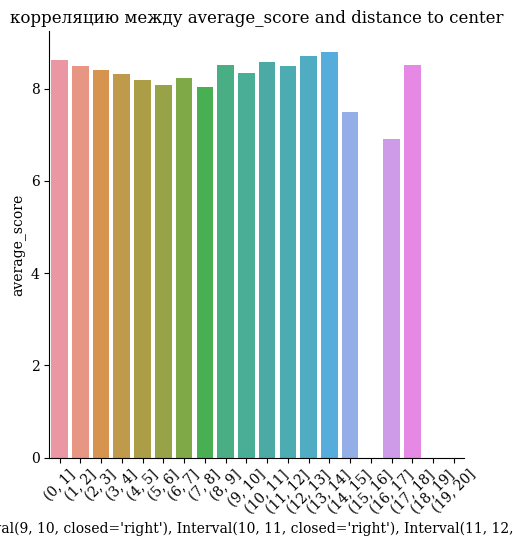

In [440]:

df = pd.DataFrame({'average_score': hotels['average_score'].groupby(
   pd.cut(hotels['to_center'],np.arange(0, 21, 1))
   ).agg('mean')})


#df['value'] = hotels['average_score'].groupby(
 #  pd.cut(hotels['to_center'],np.arange(0, 21, 1))
 #  ).agg('mean')

display(df)
index = df.index.to_list()

#display(hotels['total_number_of_reviews_reviewer_has_given'].groupby(
#   pd.cut(hotels['total_number_of_reviews_reviewer_has_given'], 
#   np.arange(0, 500, 50))
#   ).agg('count'))

# Создание меток категориий
#labels = ['{0} - {1}'.format(i, i + 9) for i in range(0, int(hotels['to_center'].max()), 5)]
labels = ['{0} - {1}'.format(i, i + 1) for i in range(0, 20, 1)]
#display(labels)

# Создание признака категорий
#df['value_group'] = pd.cut(df.value, range(0, 21, 1), right=False, labels=labels)
df = df.fillna(0)
#display(df)

fig = plt.figure(figsize=(12, 8))
ax = sns.catplot(data=df, x=index, y='average_score', kind="bar")
plt.xticks(rotation=45)
#ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
plt.title('корреляцию между average_score and distance to center')
experiment.log_figure(figure=plt)
plt.show()

there is no visibale correlation between the dosstance to the center of the city  and the average score

### chrck the correlation between average score and the city

,city,average_score
0,Amsterdam,8.387432
1,Barcelona,8.521018
2,London,8.340255
3,Milan,8.427651
4,Paris,8.408711
5,Vienna,8.557732


<Figure size 1200x800 with 0 Axes>

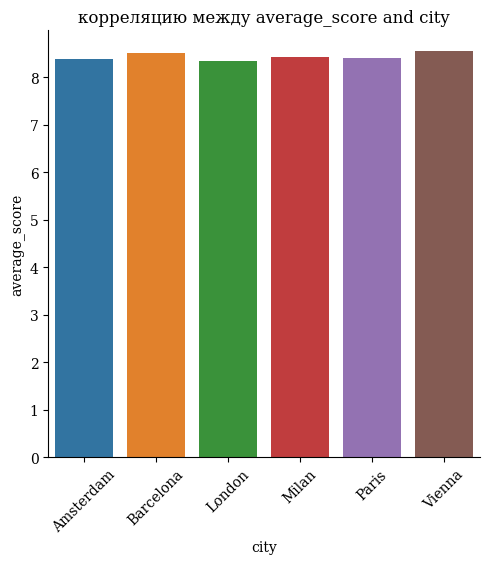

In [441]:
# Создание датафрейма
city_score = hotels[['average_score', 'city']].groupby('city', as_index=False).agg('mean')

#idx = pd.Index(range(0, len(city_list), 1))
# 
# Set the above DataFrame index object as the index
# using set_index() function
#city_score = city_score.set_index(idx, drop=False)

display(city_score)

fig = plt.figure(figsize=(12, 8))
ax = sns.catplot(data=city_score, x='city', y='average_score', kind="bar")
plt.xticks(rotation=45)
plt.title('корреляцию между average_score and city');
experiment.log_figure(figure=plt)
plt.show()

there is no visibale correlation between the cities and the average score

{'web': 'https://www.comet.com/api/image/download?imageId=7b61d619005d42a48b81c283180d058f&experimentKey=e2d052cc1ae847c7be6e1ed91d281671',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=7b61d619005d42a48b81c283180d058f&experimentKey=e2d052cc1ae847c7be6e1ed91d281671',
 'imageId': '7b61d619005d42a48b81c283180d058f'}

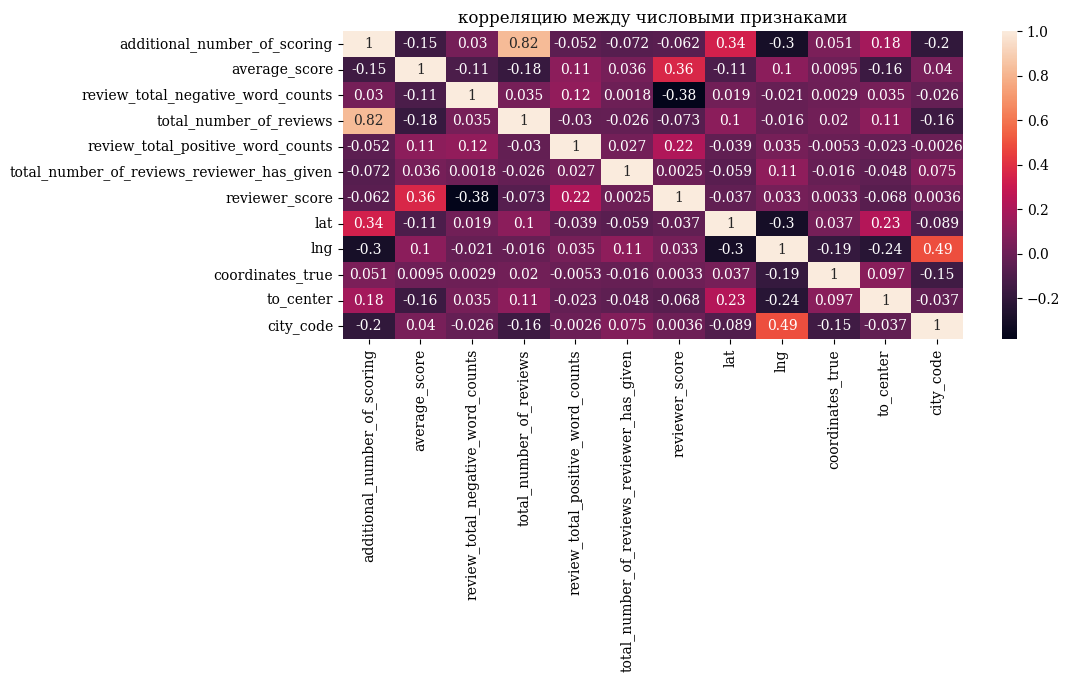

In [442]:
fig = plt.figure(figsize=(10, 4))
ax = sns.heatmap(hotels.corr(numeric_only=True), annot = True)
ax.set_title('корреляцию между числовыми признаками');
experiment.log_figure(figure=plt)

C:\Users\kot\AppData\Local\Temp\ipykernel_57924\1913497019.py:4: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



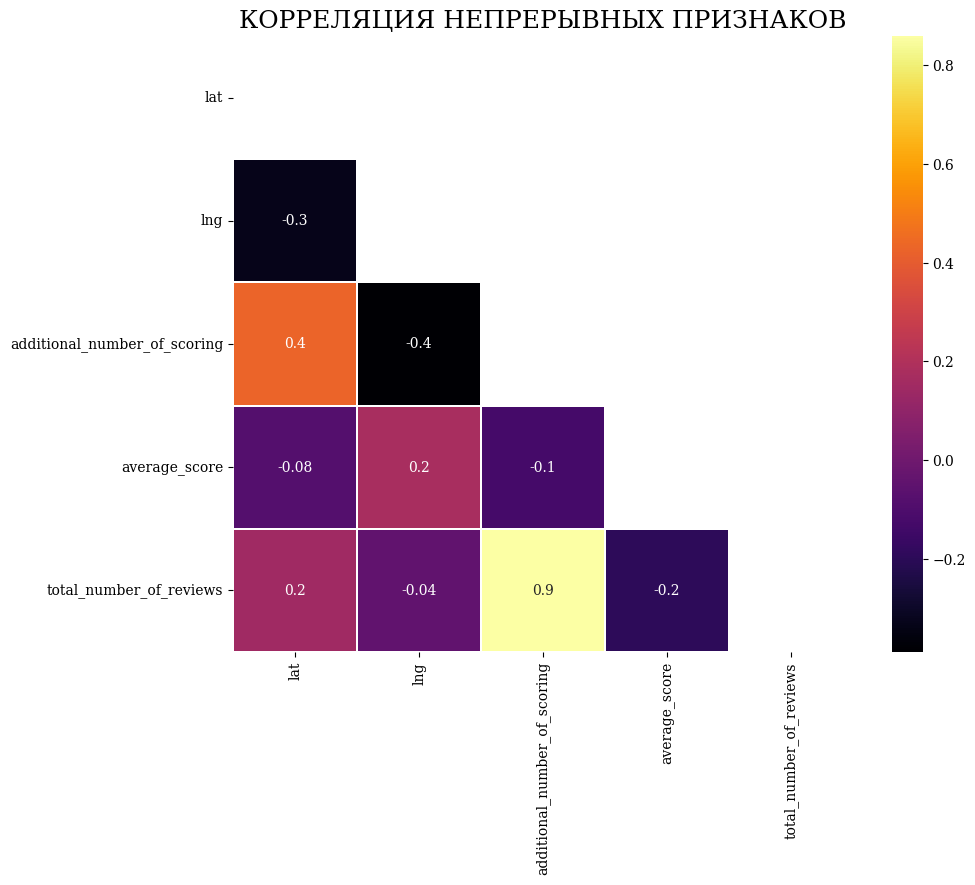

In [443]:
def show_corr_heatmap(columns_list, title, method):
    """Построения корреляционной диаграммы"""
    fig_, ax_ = plt.subplots(figsize=(10, 8))
    corr = hotels[columns_list].corr(method=method)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, 
                annot=True, 
                linewidths=0.1, 
                ax=ax_, 
                mask=mask, 
                cmap='inferno',
                fmt='.1g')
    ax_.set_title(title, fontsize=18)
    
    experiment.log_figure(figure=plt)
    plt.show()
    
    



cols_num = [
    'review_total_negative_word_counts',
    'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given',
]
#Категориальные
cols_cat = [
    'lat',
    'lng',
    'additional_number_of_scoring',
    'average_score',
    'total_number_of_reviews',
    'days_since_review',
]

show_corr_heatmap(cols_cat, 'КОРРЕЛЯЦИЯ НЕПРЕРЫВНЫХ ПРИЗНАКОВ', method='spearman'); #spearman #pearson



## 2 Analysis of reviewers citizenship 

coding as binary

In [450]:
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(lambda x: x.strip())
print("amount of different citizenships {}".format(hotels['reviewer_nationality'].nunique()))

#Top 20
print(hotels['reviewer_nationality'].value_counts(ascending=False)[:20].index.to_list())
hotels['reviewer_resident'] = hotels.apply(lambda x: 1 if x['reviewer_nationality'] == x['country'] else 0, axis=1)
display(hotels[['city', 'country', 'reviewer_nationality', 'reviewer_resident']])




amount of different citizenships 225
['United Kingdom', 'United States of America', 'Australia', 'Ireland', 'United Arab Emirates', 'Saudi Arabia', 'Netherlands', 'Switzerland', 'Canada', 'Germany', 'France', 'Israel', 'Italy', 'Belgium', 'Turkey', 'Kuwait', 'Spain', 'Romania', 'Russia', 'South Africa']


,city,country,reviewer_nationality,reviewer_resident
0,London,United Kingdom,United Kingdom,1
1,London,United Kingdom,United Kingdom,1
2,Paris,France,China,0
3,Paris,France,United Kingdom,0
4,Amsterdam,Netherlands,Poland,0
...,...,...,...,...
386798,London,United Kingdom,France,0
386799,Vienna,Austria,Turkey,0
386800,London,United Kingdom,Netherlands,0
386801,London,United Kingdom,United Arab Emirates,0


In [457]:

# Создание экземпляра класса OrdinalEncoder()
#ord_enc = ce.OrdinalEncoder()
#data_ord = ord_enc.fit_transform(hotels['reviewer_nationality'])
#hotels = pd.concat([hotels, data_ord], axis=1)

# Создание экземпляра класса OneHotEncoder()
#ohe_enc = ce.OneHotEncoder(cols=['reviewer_nationality'])
#data_ohe = ohe_enc.fit_transform(hotels['reviewer_nationality'])
#hotels = pd.concat([hotels, data_ohe], axis=1)

# Создание экземпляра класса BinaryEncoder()
bin_enc = ce.BinaryEncoder(cols=['reviewer_nationality'])
data_bin = bin_enc.fit_transform(hotels['reviewer_nationality'])
hotels = pd.concat([hotels, data_bin], axis=1)

display(hotels)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,reviewer_nationality_6,reviewer_nationality_7,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,...,0,1,0,0,0,0,0,0,0,1
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,...,0,1,0,0,0,0,0,0,0,1
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,...,1,0,0,0,0,0,0,0,1,0
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,...,0,1,0,0,0,0,0,0,0,1
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,...,1,1,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386798,9 Knaresborough Place Kensington and Chelsea L...,107,4/19/2017,9.0,Hotel Moonlight,France,No Negative,0,617,Tr s proche du metro Earl s court,...,0,0,0,0,0,0,0,1,0,0
386799,Landstra er Hauptstra e 155 03 Landstra e 1030...,272,2/13/2017,8.4,BEST WESTERN PLUS Amedia Wien,Turkey,No Negative,0,3224,The bed was so comfy I stayed with my boyfrie...,...,1,1,0,0,1,0,1,0,1,1
386800,29 31 Gower Street Camden London WC1E 6HG Unit...,457,2/7/2016,6.8,Bloomsbury Palace Hotel,Netherlands,room is really small but guess is normal in L...,12,2751,great location simple check in out nice shower,...,1,1,0,0,0,0,1,1,1,1
386801,31 Great Cumberland Place Westminster Borough ...,365,5/21/2017,8.1,The Marble Arch London,United Arab Emirates,No Negative,0,1567,Location and very comfy bed,...,0,0,0,0,0,0,1,0,0,0


## 3. Tag analysis

In [588]:
display(hotels['tags'])
# max tags count
print("max tags count {}".format(hotels['tags'].apply(lambda x: len(x.split(','))).max()))

#find all unique tags
print(hotels[hotels['tags'].apply(lambda x: len(x.split(','))) == 6]['tags'].iloc[0])
print(hotels[hotels['tags'].apply(lambda x: len(x.split(','))) == 6]['tags'].iloc[1])
print(hotels[hotels['tags'].apply(lambda x: len(x.split(','))) == 6]['tags'].iloc[2])

tag_set = set()
tag_list = []
str1 = "[' With a pet ', ' Leisure trip ', ' Family with young children ', ' Double or Twin Room 1 2 Adults ', ' Stayed 7 nights ', ' Submitted from a mobile device ']"
str2 = "[' With a pet ', ' Leisure trip ', ' Couple ', ' Deluxe Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']" 
#tag_set.update(str1)
#print(tag_set)

#tag_set.update(str2)
#print(tag_set)

def tag_parce(set1, st1):
    st1 = re.sub("[\[\]\"\']", '', st1)
    lst = st1.split(",")
    for el in lst:
        set1.add(el.strip())
    print(set1)
    #return set1
    

tag_parce(tag_set, str1)
tag_list = list(tag_set)
print(tag_list)

####hotels.apply(lambda raw: tag_parce(tag_set, raw.tags), axis=1)

#hotels['tags'].apply(lambda raw: tag_parce(tag_set, raw))
#print(len(tag_list))

def find_tag(st1, pattern):
    st1 = re.sub("[\[\]\"\']", '', st1)
    lst = st1.lower().split(",")
    lst = list(map(lambda x: x.strip(), lst))
    for el in lst:
        if re.findall(pattern, el):
            return el


# 6 different tag types:
#Trip type
#Pets
#submitted
#traveler type
#numbers of nights
#room type

 
list_trip = hotels['tags'].iloc[0:1000].apply(lambda raw: find_tag(raw, "leisure|business")).to_list()
print(set(list_trip))
list_trip = hotels['tags'].iloc[0:1000].apply(lambda raw: find_tag(raw, "pet")).to_list()
print(set(list_trip))
list_trip = hotels['tags'].iloc[0:1000].apply(lambda raw: find_tag(raw, "submitted")).to_list()
print(set(list_trip))
list_trip = hotels['tags'].iloc[0:1000].apply(lambda raw: find_tag(raw, "solo|couple|friends|family|group")).to_list()
print(set(list_trip))
list_trip = hotels['tags'].iloc[0:1000].apply(lambda raw: find_tag(raw, "stayed")).to_list()
print(set(list_trip))
list_trip = hotels['tags'].iloc[0:1000].apply(lambda raw: find_tag(raw, "room")).to_list()
print(set(list_trip))



0         [' Leisure trip ', ' Couple ', ' Studio Suite ...
1         [' Business trip ', ' Couple ', ' Standard Dou...
2         [' Leisure trip ', ' Solo traveler ', ' Modern...
3         [' Leisure trip ', ' Solo traveler ', ' Standa...
4         [' Business trip ', ' Couple ', ' Standard Dou...
                                ...                        
386798    [' Leisure trip ', ' Group ', ' Club Double or...
386799    [' Leisure trip ', ' Couple ', ' Standard Doub...
386800    [' Business trip ', ' Solo traveler ', ' Singl...
386801    [' Leisure trip ', ' Solo traveler ', ' Deluxe...
386802    [' Leisure trip ', ' Couple ', ' Bunk Bed Room...
Name: tags, Length: 386803, dtype: object

max tags count 6
[' With a pet ', ' Leisure trip ', ' Solo traveler ', ' Standard Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']
[' With a pet ', ' Leisure trip ', ' Group ', ' Superior Twin Room ', ' Stayed 3 nights ', ' Submitted from a mobile device ']
[' With a pet ', ' Leisure trip ', ' Family with young children ', ' Family Room ', ' Stayed 3 nights ', ' Submitted from a mobile device ']
{'Double or Twin Room 1 2 Adults', 'Family with young children', 'Submitted from a mobile device', 'Leisure trip', 'With a pet', 'Stayed 7 nights'}
['Double or Twin Room 1 2 Adults', 'Family with young children', 'Submitted from a mobile device', 'Leisure trip', 'With a pet', 'Stayed 7 nights']
{'business trip', 'leisure trip', None}
{'with a pet', None}
{None, 'submitted from a mobile device'}
{'couple', 'group', 'family with older children', 'travelers with friends', 'solo traveler', 'family with young children'}
{'stayed 7 nights', 'stayed 8 nights', 'stayed 6 nights',

### 3.2 create new attributes

add the attributes representing the traveller types

In [594]:
def find_tag_all(st1):
    reviewer_types = {'solo traveler': 1,
                      'couple': 2,
                      'travelers with friends': 3,
                      'family with young children': 4,
                      'family with older children': 5,
                      'group': 6}
    
    # returned variables:
    tag_from_mobile = 0
    tag_with_pet = 0
    tag_leisure_trip = 0
    tag_reviewer_type = 0
    tag_count_nights = 0
    tag_room_type = ''
    
    st1 = re.sub("[\[\]\"\']", '', st1)
    tag_list = st1.lower().split(",")
    tag_list = list(map(lambda x: x.strip(), tag_list))
    
    for tag in list(tag_list):
        if re.findall("Submitted from a mobile device", tag):
            tag_from_mobile = 1
            tags_list.remove(tag)
    
        if re.findall("with a pet", tag):
            tag_with_pet = 1
            tag_list.remove(tag)
            
        if re.findall("leisure trip", tag):
            tag_leisure_trip = 1
            tag_list.remove(tag)
        
        if re.findall("business trip", tag):
            tag_list.remove(tag)
            
        if tag in reviewer_types.keys():
            tag_reviewer_type = reviewer_types[tag]
            tag_list.remove(tag)
            
        if re.findall(r'stayed\s\d+\snight', tag):
            tag_count_nights = re.findall(r'stayed\s(\d+)\snight', tag)[0]
            tag_list.remove(tag)
        
    if len(tag_list):
        tag_room_type = tag_list[0]
    
    return tag_from_mobile, tag_with_pet, tag_leisure_trip, \
        tag_reviewer_type, tag_count_nights, tag_room_type


list_trip = hotels['tags'].iloc[0:10].apply(lambda raw: find_tag_all(raw)).to_list()
print(list_trip)

        
hotels[['tag_from_mobile',
        'tag_with_pet',
        'tag_leisure_trip',
        'tag_reviewer_type',
        'tag_count_nights',
        'tag_room_type']
] = pd.DataFrame(hotels['tags'].apply(find_tag_all).to_list(), index=hotels.index)

hotels['tag_count_nights'] = hotels['tag_count_nights'].astype('int8')

display(hotels[['tag_from_mobile', 'tag_with_pet', 'tag_leisure_trip', 
        'tag_reviewer_type', 'tag_count_nights', 'tag_room_type']].nunique())

[(0, 0, 1, 2, '2', 'studio suite'), (0, 0, 0, 2, '1', 'standard double room'), (0, 0, 1, 1, '3', 'modern double room echo'), (0, 0, 1, 1, '1', 'standard room with 1 double bed'), (0, 0, 0, 2, '6', 'standard double or twin room'), (0, 0, 0, 1, '1', 'superior twin room'), (0, 0, 1, 2, '1', 'double room non smoking'), (0, 0, 1, 2, '4', 'superior double room'), (0, 0, 1, 2, '1', 'double room'), (0, 0, 1, 2, '1', 'twin hilton guest room')]


tag_from_mobile         1
tag_with_pet            2
tag_leisure_trip        2
tag_reviewer_type       6
tag_count_nights       31
tag_room_type        2323
dtype: int64

### 3.3 parce the room types

add a new attribute representing the rooms with some nice view (except the garden and internal views)

In [613]:
#add the view attribute
hotels['tag_view_room'] = hotels['tag_room_type'].apply(
    lambda x: 1 if ((('view' in x) | ('panoramic' in x)) & ('garden' not in x) & ('internal' not in x) & ('courtyard' not in x))  else 0)
display(hotels[hotels['tag_view_room'] == 1]['tag_room_type'])

#check the room type
def get_room_type(tag):
    room_types = ['without window', 'guestroom', 'classic', 'single', 
                  'standard', 'superior', 'comfort', 'club', 'suite', 
                  'deluxe', 'king', 'premier', 'executive', 'studio']

    for el in room_types:
        if el in tag:
            return el

    if 'double' in tag or 'twin' in tag:
        return 'double'

    return 'Other'

hotels['room_type'] = hotels['tag_room_type'].apply(get_room_type)
print(hotels['room_type'].nunique())


54        deluxe double room with eiffel tower view
97            premium double or twin room with view
118             standard double room with park view
124               executive studio city view family
145                               river view deluxe
                            ...                    
386594             deluxe king room with river view
386655            deluxe double room with city view
386676                     king room with pool view
386719                      twin room with sea view
386759                   double room with city view
Name: tag_room_type, Length: 10664, dtype: object

16


### 3.4 encode new atributes

room type we can encode using OneHotEncoder as the unique number is relative small (less then 20)

In [616]:
encoder_r = ce.OneHotEncoder(cols=['room_type'], use_cat_names=True)
tag_rooms_bin = encoder_r.fit_transform(hotels['room_type'])
hotels = pd.concat([hotels, tag_rooms_bin], axis=1)

display(hotels.iloc[100:105:1])


c:\Users\kot\OneDrive\Documents\GitHub\SkillFactory-DTS\venv\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,room_type_comfort,room_type_executive,room_type_studio,room_type_deluxe,room_type_without window,room_type_premier,room_type_classic,room_type_single,room_type_guestroom,room_type_club
100,5 Curzon St Westminster Borough London W1J 5HL...,431,8/1/2016,7.9,Washington Mayfair Hotel,Australia,Service could be improved Bit more warmth wou...,21,1532,Location was great Rooms were clean Bed was c...,...,0,0,0,1,0,0,0,0,0,0
101,Mallorca 269 271 Eixample 08008 Barcelona Spain,87,9/29/2015,9.2,Alma Barcelona GL,Japan,It s a shame the widely advertised roof terra...,49,593,Hotel location is great rooms are comfortable...,...,0,0,0,0,0,0,0,0,0,0
102,21 rue de Dunkerque 10th arr 75010 Paris France,740,2/14/2017,7.4,Mercure Paris Terminus Nord,France,I haven t been given the invoice I ll have to...,17,5575,No Positive,...,0,0,0,0,0,0,0,1,0,0
103,173 185 Greenwich High Rd Greenwich London SE1...,274,6/23/2017,8.6,Novotel London Greenwich,Canada,The room carpet was filthy and the room smell...,27,924,Lady clerk at the front desk was very helpful,...,0,0,0,0,0,0,0,0,0,0
104,1 3 Queens Garden Westminster Borough London W...,1058,10/27/2015,7.7,The Park Grand London Paddington,United Kingdom,No Negative,0,4380,well looked after by the staff nothing was to...,...,0,0,0,1,0,0,0,0,0,0


### 3.5 visualise the correlation  
between the room type the average score

and the amount of nights and amount of scores


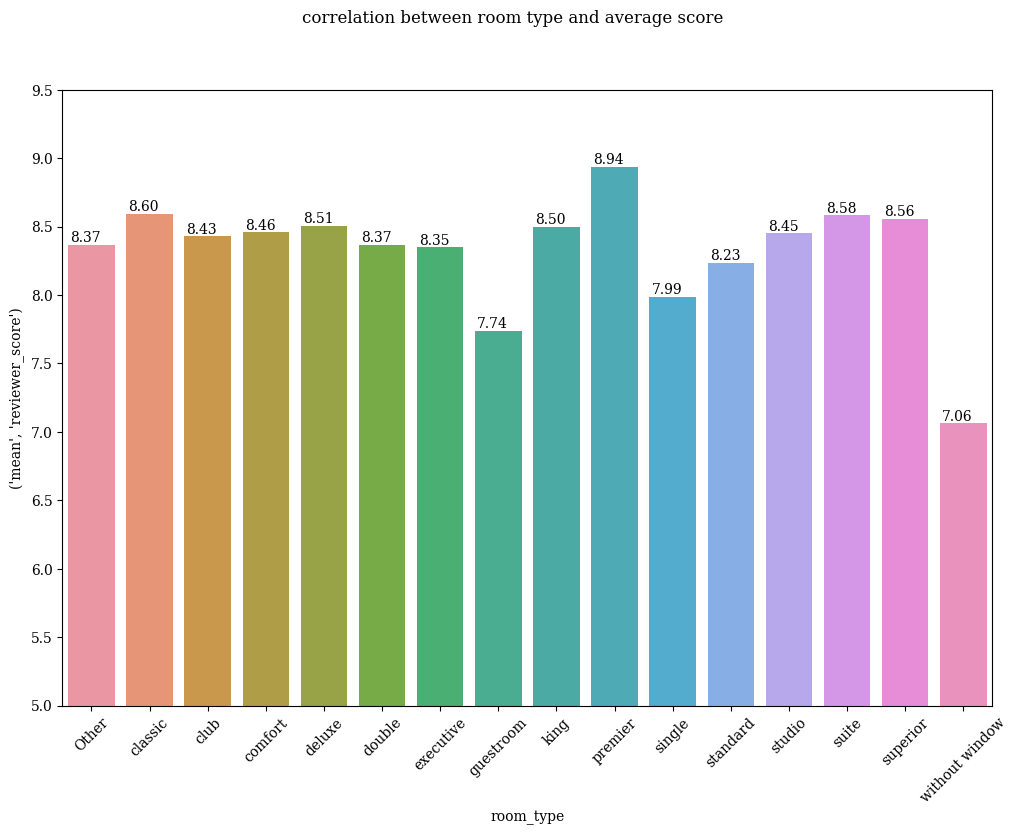

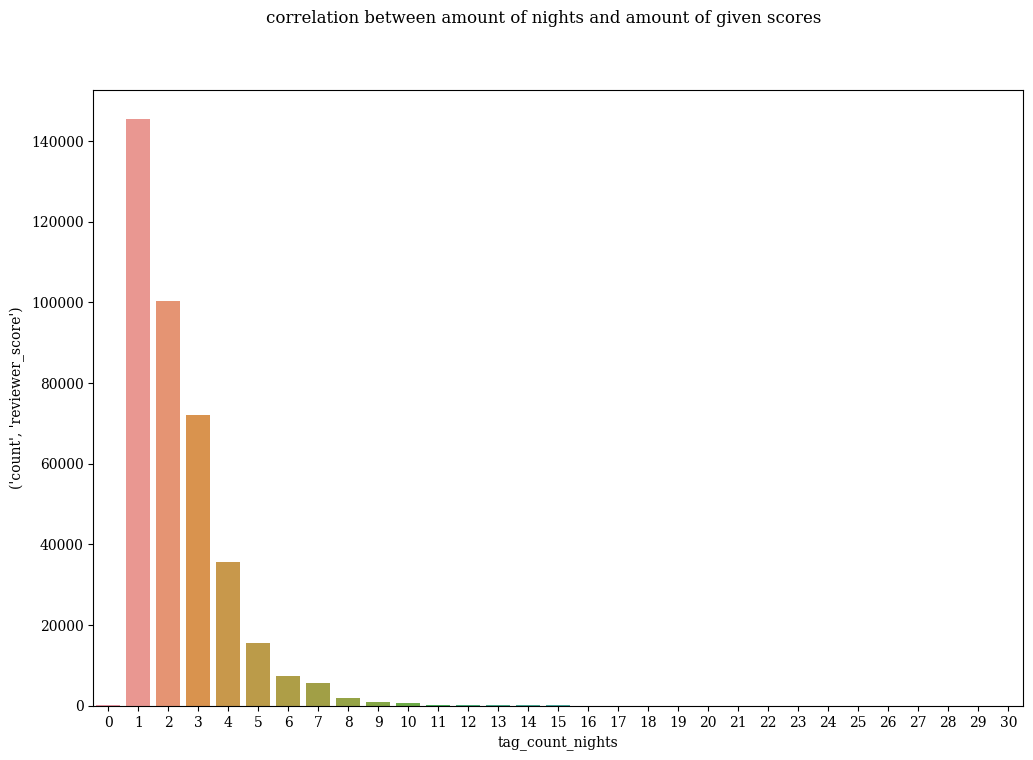

In [634]:
pivot_types = pd.pivot_table(hotels[hotels['sample'] == 1], 
                             index='room_type', 
                             values='reviewer_score', 
                             aggfunc=['mean'])

ax3 = plt.subplots(figsize=(12, 8))
plt.suptitle('correlation between room type and average score')
bar_types = sns.barplot(
    x=pivot_types.index, 
    y=pivot_types[('mean', 'reviewer_score')])

for p in bar_types.patches:
    bar_types.annotate('{:.2f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
    ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=45)
plt.ylim(5, 9.5);


pivot_types = pd.pivot_table(hotels[hotels['sample'] == 1], 
                             index='tag_count_nights', 
                             values='reviewer_score', 
                             aggfunc=['count'])

ax4 = plt.subplots(figsize=(12, 8))
plt.suptitle('correlation between amount of nights and amount of given scores')
bar_types = sns.barplot(
    x=pivot_types.index, 
    y=pivot_types[('count', 'reviewer_score')])

1. the better the room type, the higher the review score, the loewest are simplest room types - guestroom and  without window
2. the most amount of reviews are given for 1-3 night stays, typical for the business and city hotel. The number of reviews dramatically goes down for stays longer then 7 days, which is typical for the holiday hotels

In [25]:
import dtale
import sweetviz as sv
from pandas_profiling import ProfileReport


In [ ]:
profile = ProfileReport(hotels, title="Hotels Pandas Profiling Report")
display(profile)


In [458]:
d = dtale.show(hotels)
display(d)

Exception: data contains duplicated column names: reviewer_nationality_0, reviewer_nationality_1, reviewer_nationality_2, reviewer_nationality_3, reviewer_nationality_4, reviewer_nationality_5, reviewer_nationality_6, reviewer_nationality_7

# Remove and fill

In [28]:

object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
hotels.drop(object_columns, axis = 1, inplace=True)

# заполняем пропуски самым простым способом
values = {
    'lng': hotels['lng'].mode()[0],
    'lat': hotels['lat'].mode()[0]
    
}
hotels = hotels.fillna(value=values) 


In [215]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score'] 

In [216]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

In [217]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [218]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  

random_state = 42  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


ValueError: could not convert string to float: 'Pla a de Llevant s n Sant Mart 08019 Barcelona Spain'

In [214]:


# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')



NameError: name 'model' is not defined

In [33]:
params={"random_state":random_state,
        "model_type":"regr"
}
experiment.log_parameters(params)


In [34]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.14132658675129842


In [37]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)

print("Доля правильных ответов: {:6.3f}".format(accuracy))

#metrics = {"accuracy":accuracy}
#experiment.log_metrics(metrics)
experiment.log_confusion_matrix(y_test.tolist(), y_pred.tolist())

ValueError: continuous is not supported

Небольшой бонус:


In [10]:
# # убираем признаки которые еще не успели обработать, 
# # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
# object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
# hotels.drop(object_columns, axis = 1, inplace=True)

# # заполняем пропуски самым простым способом
# hotels = hotels.fillna(0)

In [ ]:
experiment.end()